# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [75]:
%matplotlib inline
import lightkurve as lk
import gatspy
import numpy as np
import pandas as pd

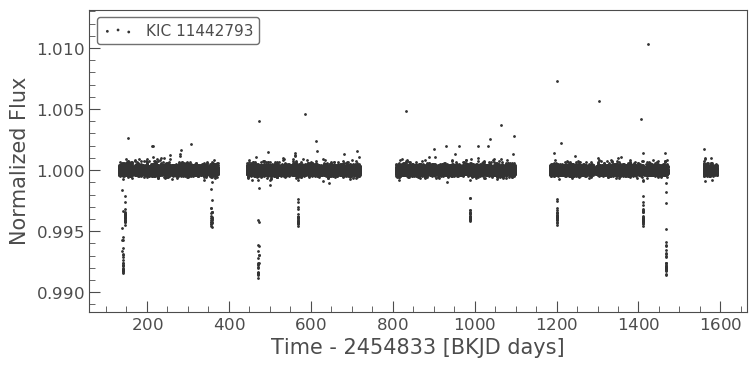

In [29]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

### Following the linked lightkurve tutorial (scratch code/seeing what all this is)

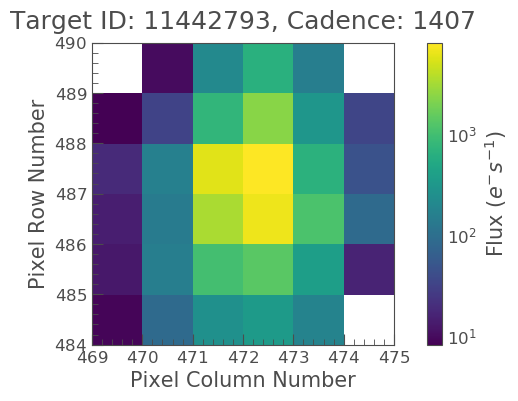

In [27]:
#pixel data at one point in time
#using frame index 300, looking at observing quarter 1

tpf = lk.search_targetpixelfile("Kepler-90", quarter=1).download()
tpf.plot(frame=300, scale='log', show_colorbar=True);

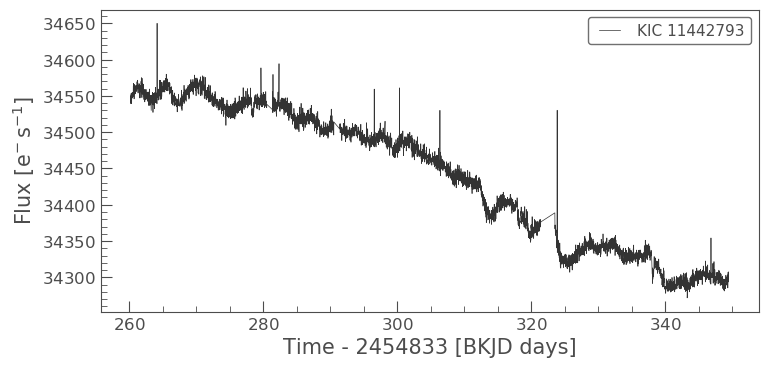

In [6]:
#looking at the photometry lightcurve (not normalized flux)
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

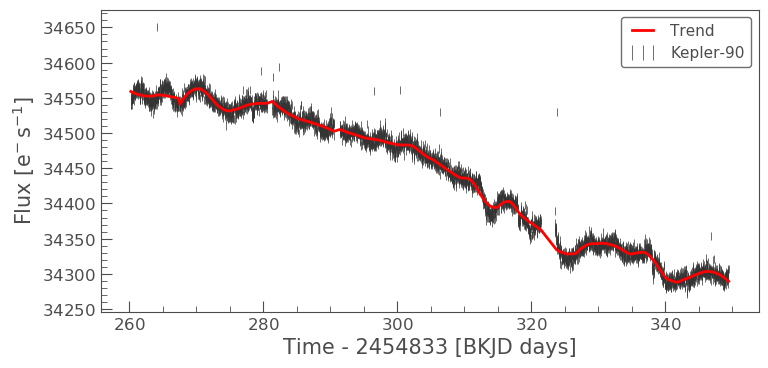

In [7]:
#remove long-term variability with flatten method and plot estimated trend

flat, trend = lc.flatten(window_length=301, return_trend=True)
ax = lc.errorbar(label="Kepler-90")
trend.plot(ax=ax, color='red', lw=2, label='Trend');

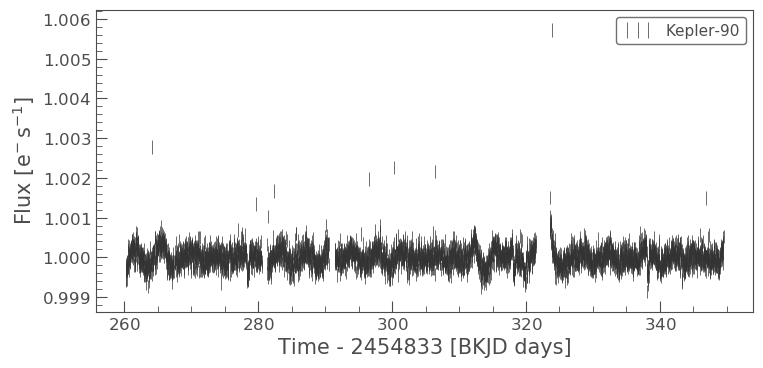

In [33]:
#the flattened lightcurve

flat.errorbar(label="Kepler-90")

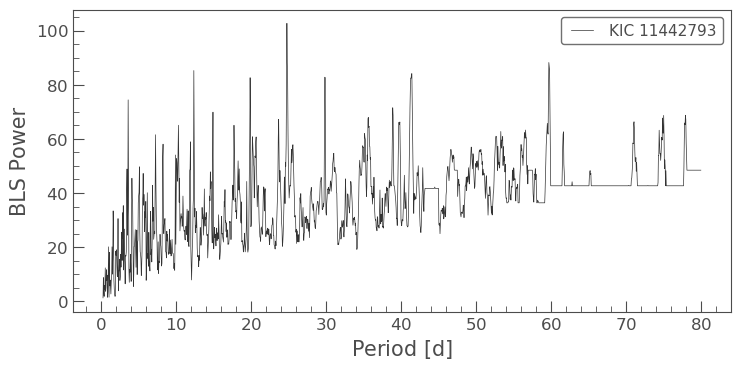

In [21]:
periodogram = flat.to_periodogram(method="bls", period=np.arange(0.3,80,.05))
periodogram.plot()

### The most prominent spikes in this periodogram reveal the periodicities of potential exoplanets.

### now that I have a better idea of the data, going to do the same periodogram but with the corrected light curve provided

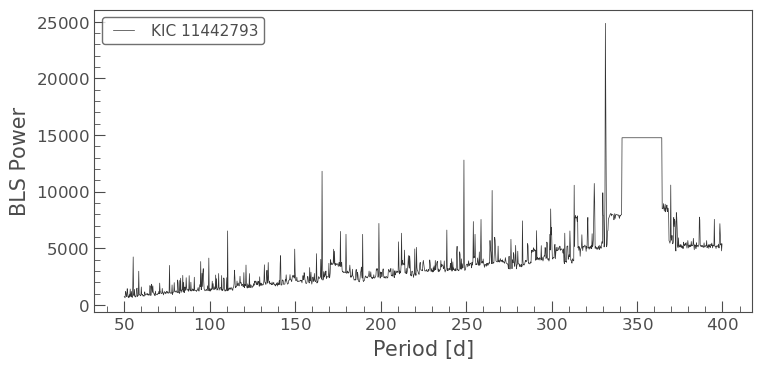

In [90]:
pdgm = clc.to_periodogram(method="bls", period=np.arange(50,400,.25))
pdgm.plot()

### this looks a bit easier to read
### certainly there is a strong signal between 300 and 350. lets confirm the exact value

In [99]:
best_fit_period = pdgm.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period))

Best fit period: 331.500 d


In [100]:
pdgm.transit_time_at_max_power

140.6624394588347

# Planet 1

Text(0.5, 1.0, 'planet 1')

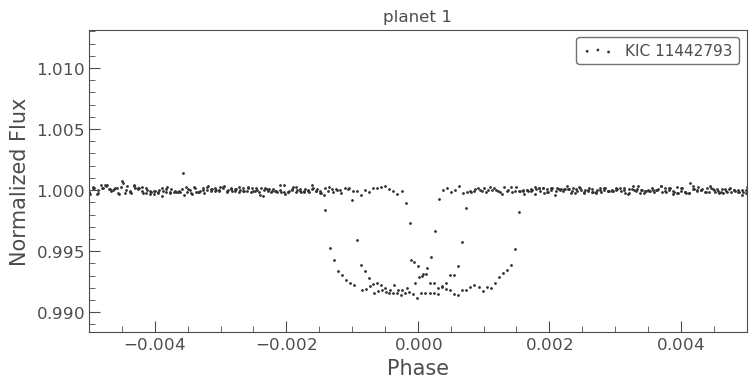

In [105]:
ax = clc.fold(period=best_fit_period, t0=pdgm.transit_time_at_max_power).scatter()
ax.set_xlim(-.005,.005)
ax.set_title('planet 1')

### now use the masking function from lightkurve

In [114]:
mask1 = pdgm.get_transit_mask(period = best_fit_period, duration = pdgm.duration_at_max_power, 
                             transit_time = pdgm.transit_time_at_max_power)

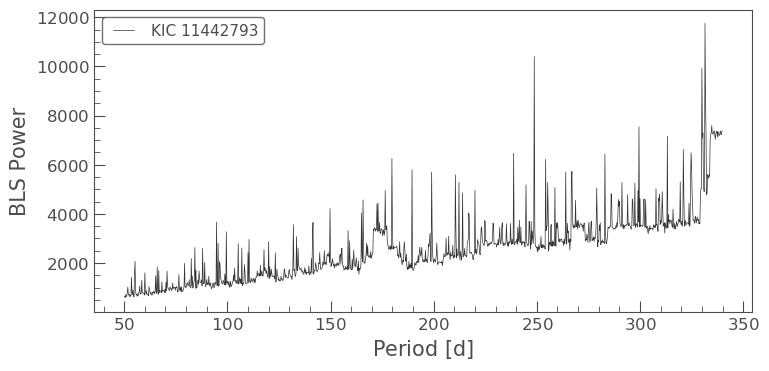

In [120]:
clc2 = clc[mask1]
pdgm2 = clc2.to_periodogram(method="bls", period=np.arange(50,340,.25))
pdgm2.plot()

In [121]:
best_fit_period2 = pdgm2.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period2))

Best fit period: 331.500 d


### ??? ok this might defeat the purpose of masking, but i feel like 250 is the value i'm looking for so we're gonna trim the 331.5 out since we just did that one. (sorry if that's cheating)

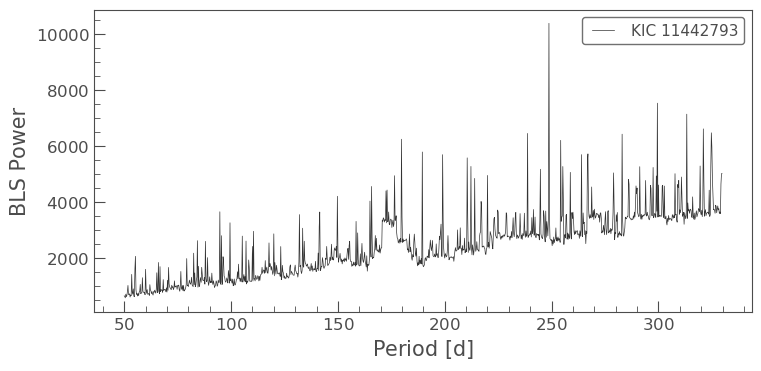

In [122]:
clc2 = clc[mask1]
pdgm2 = clc2.to_periodogram(method="bls", period=np.arange(50,330,.25))
pdgm2.plot()

In [123]:
best_fit_period2 = pdgm2.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period2))

Best fit period: 248.750 d


# Planet 2

Text(0.5, 1.0, 'planet 2')

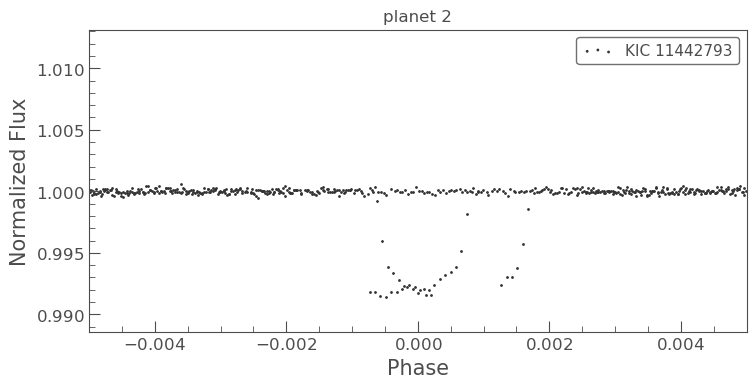

In [125]:
ax = clc2.fold(period=best_fit_period2, t0=pdgm2.transit_time_at_max_power).scatter()
ax.set_xlim(-.005,.005)
ax.set_title('planet 2')

## ¯ \ _(ツ)_/¯

### masking again

In [126]:
mask2 = pdgm2.get_transit_mask(period = best_fit_period2, duration = pdgm2.duration_at_max_power, 
                             transit_time = pdgm2.transit_time_at_max_power)

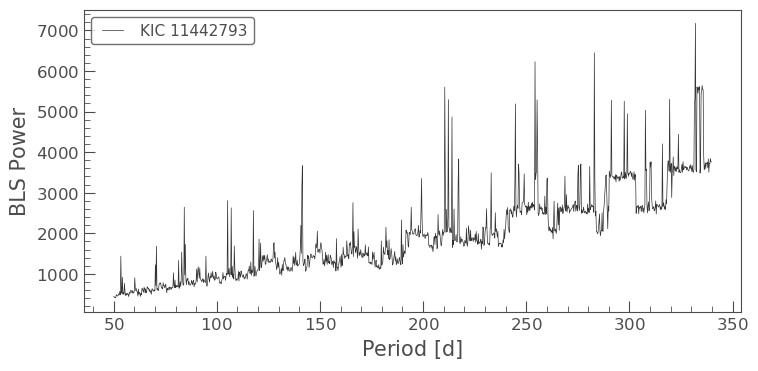

In [130]:
clc3 = clc2[mask2]
pdgm3 = clc3.to_periodogram(method="bls", period=np.arange(50,340,.25))
pdgm3.plot()

In [131]:
best_fit_period2 = pdgm2.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period2))

Best fit period: 248.750 d


### okay so it happened again (output former max value)... maybe i can apply another mask?

In [133]:
mask2pt1 = pdgm3.get_transit_mask(period = best_fit_period3, duration = pdgm3.duration_at_max_power, 
                             transit_time = pdgm3.transit_time_at_max_power)

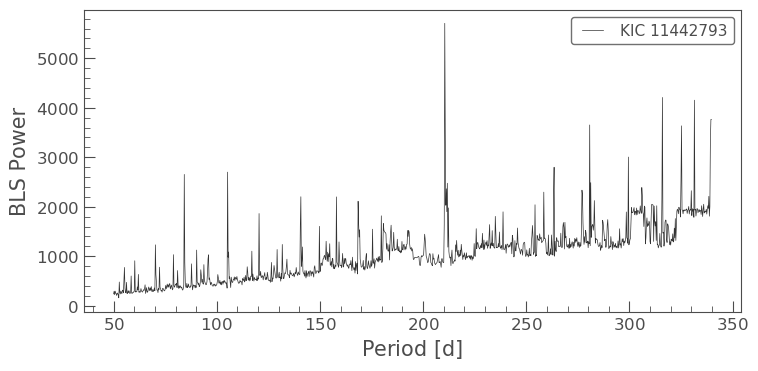

In [136]:
clc3pt1 = clc3[mask2pt1]
pdgm3pt1 = clc3pt1.to_periodogram(method="bls", period=np.arange(50,340,.25))
pdgm3pt1.plot()

In [138]:
best_fit_period3 = pdgm3pt1.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period3))

Best fit period: 210.500 d


# Planet 3

Text(0.5, 1.0, 'planet 3')

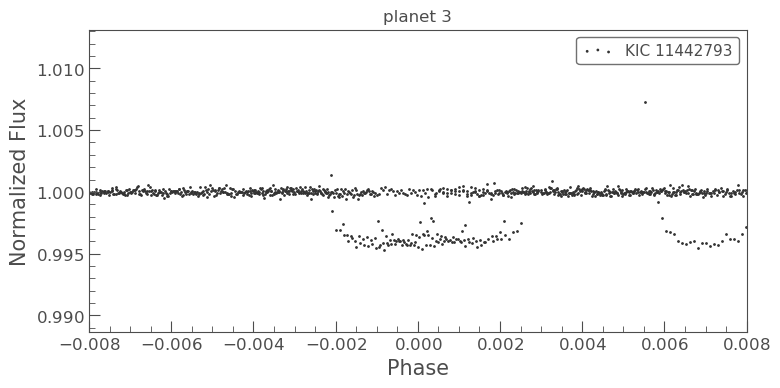

In [141]:
ax = clc3pt1.fold(period=best_fit_period3, t0=pdgm3pt1.transit_time_at_max_power).scatter()
ax.set_xlim(-.008,.008)
ax.set_title('planet 3')

## Conclusion: Found exoplanets at perodicities 331.5 d, 248.75 d, and 210.5 d